In [19]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
# Importing necessary libraries
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import numpy as np


In [21]:
clean_data = pd.read_csv("dataset/dataset_tokenized.csv")
clean_data.head()

,tweet_text,image_path,labels,input_ids,attention_mask
0,nigga,dataset/images/0.jpg,"[4, 1, 3]","tensor([ 101, 9152, 23033, 102, 0, ...","tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,my horses are retarded,dataset/images/1.jpg,"[5, 5, 5]","tensor([ 101, 2026, 5194, 2024, 2128, 7559, 57...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,..."
2,nigga on ma momma youngboy be spitting real sh...,dataset/images/2.jpg,"[0, 0, 0]","tensor([ 101, 9152, 23033, 2006, 5003, 236...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,rt xxsugvngxx i ran into this holy nigga today,dataset/images/3.jpg,"[1, 0, 0]","tensor([ 101, 19387, 22038, 6342, 2290, 160...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,everybody calling you nigger now,dataset/images/4.jpg,"[1, 0, 1]","tensor([ 101, 7955, 4214, 2017, 9152, 133...","tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,..."


In [22]:
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet-50
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Function to load and transform images with validation
def load_and_transform_image(image_path):
    try:
        # Ensure the image path is absolute
        if not os.path.isabs(image_path):
            # Construct the absolute path
            base_dir = ""
            image_path = os.path.join(base_dir, image_path)
        
        # Open and convert the image to RGB
        image = Image.open(image_path).convert("RGB")
        
        # Apply transformations
        transformed_image = transform(image)
        
        # Validate the transformed image
        if not isinstance(transformed_image, torch.Tensor):
            raise ValueError("Transformed image is not a tensor.")
        if transformed_image.shape != (3, 224, 224):
            raise ValueError(f"Unexpected image shape: {transformed_image.shape}")
        
        # Check if pixel values are within a reasonable range after normalization
        if transformed_image.min() < -3 or transformed_image.max() > 3:
            raise ValueError("Image pixel values are outside the expected range after normalization.")
        
        print(f"Successfully transformed image: {image_path}")
        return transformed_image
    
    except Exception as e:
        print(f"Error loading or transforming image {image_path}: {e}")
        return transform(Image.new("RGB", (224, 224), color="black"))  # Return a black image if loading fails

# Apply image transformations to the dataset
clean_data["image"] = clean_data["image_path"].apply(load_and_transform_image)

# Save transformed images and update the dataset
transformed_images_dir = "dataset/transformed_images"
os.makedirs(transformed_images_dir, exist_ok=True)

# Save transformed images and store their paths
image_paths = []
for idx, row in clean_data.iterrows():
    image_tensor = row["image"]
    image_name = f"{idx}.pt"  # Save as .pt file
    image_path = os.path.join(transformed_images_dir, image_name)
    torch.save(image_tensor, image_path)  # Save the tensor
    image_paths.append(image_path)

# Add the transformed image paths to the DataFrame
clean_data["transformed_image_path"] = image_paths

# Drop the "image" column (tensors cannot be saved to CSV)
clean_data = clean_data.drop(columns=["image"])

# Save the updated dataset to a CSV file
clean_data.to_csv("dataset/dataset_transformed.csv", index=False)
print("Dataset saved to dataset/dataset_transformed.csv")

Successfully transformed image: dataset/images/0.jpg
Successfully transformed image: dataset/images/1.jpg
Successfully transformed image: dataset/images/2.jpg
Successfully transformed image: dataset/images/3.jpg
Successfully transformed image: dataset/images/4.jpg
Successfully transformed image: dataset/images/5.jpg
Successfully transformed image: dataset/images/6.jpg
Successfully transformed image: dataset/images/7.jpg
Successfully transformed image: dataset/images/8.jpg
Successfully transformed image: dataset/images/9.jpg
Successfully transformed image: dataset/images/10.jpg
Successfully transformed image: dataset/images/11.jpg
Successfully transformed image: dataset/images/12.jpg
Successfully transformed image: dataset/images/13.jpg
Successfully transformed image: dataset/images/14.jpg
Successfully transformed image: dataset/images/15.jpg
Successfully transformed image: dataset/images/16.jpg
Successfully transformed image: dataset/images/17.jpg
Successfully transformed image: datase

In [23]:

# Load the tensor from the .pt file
image_tensor = torch.load('dataset/transformed_images/0.pt')

# Check the basic properties of the tensor
print(f"Shape: {image_tensor.shape}")
print(f"Data type: {image_tensor.dtype}")
print(f"Min value: {image_tensor.min()}")
print(f"Max value: {image_tensor.max()}")

Shape: torch.Size([3, 224, 224])
Data type: torch.float32
Min value: -2.1179039478302
Max value: 2.640000104904175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


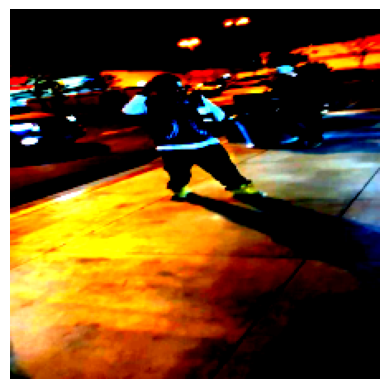

In [24]:
# It's a single image tensor with shape [C, H, W]
def show_tensor_image(tensor):
    # Convert to numpy and transpose the dimensions
    if tensor.dim() == 3 and tensor.shape[0] in [1, 3]:
        # [C, H, W] -> [H, W, C]
        img = tensor.permute(1, 2, 0).numpy()
        
        # For single channel images
        if img.shape[2] == 1:
            img = img.squeeze(2)
            plt.imshow(img, cmap='gray')
        else:
            # For RGB images, in case of normalization
            plt.imshow(img)
    else:
        plt.imshow(tensor.numpy())
    
    plt.axis('off')
    plt.show()

# Call the function
show_tensor_image(image_tensor)